# Notebook Taxi Chicago Analysis 



This notebook is organised as follow:     


1. Introduction and objectives
2. Data exploration
3. Business objective
4. Best pickup location?
5. Revenue Explanation
6. What day? What time?


## 1. Introduction and objectives

Taxi drivers are always looking for ride in order to pay their bills and more simply make money. In this way, theyr might be ways for them to succeed in making more money simply by looking for the right rides and maximise revenues or profit.

Having a look into the data can be usefull to figure out the best pick up location, the best time or day of the week to work.

## 2. Data exploration

In [ ]:
#first let do all the import needed for the note book
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import math
import datetime
%matplotlib inline

#then load the data either the whole data (1year or just 1 month)  
full_data=True 
files_to_merge = listdir('./chicago-taxi-rides-2016/')
df = pd.DataFrame()
if full_data:
    for i in files_to_merge:
        df= pd.concat([df,pd.read_csv('./chicago-taxi-rides-2016/'+i)],sort=True)
else:
    df= pd.read_csv('./chicago-taxi-rides-2016/chicago_taxi_trips_2016_01.csv')
# restraint for now to smaller dataset

print(df.head(10))
print(df.shape)

We start by checking the null and data that we not recorded

In [ ]:
column_missings = df.isnull().mean()
column_missings

Most data has acceptable quality besides the 'pickup_census_tract' field. Company is no mandatory since taxis can be independent. Finally, some of the location data may be missing because of taxi rides coming or going outside of Chicago city. 
Maybe we are looking for the wrong data issues, what about the data that is 0 or too large


In [ ]:
if full_data:
    df=df.drop(axis=1, columns=['Unnamed: 0','pickup_census_tract'])
df.head()

In [ ]:
df.describe()

More that 25% percent of the rides have 0 miles. we also have trips of zero seconds and some for free.
On the other hand, we have trips with fair of 9000usd and totalling 3280 miles.

Do people pay cash or by credit Cash?

In [ ]:
from pandas import pivot_table
status_vals = df.payment_type.value_counts()
# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

(status_vals/df.shape[0]).plot(kind="bar");
plt.title("Which mean of payment do people use?");

In [ ]:
count_rides = df.pickup_community_area.value_counts()
# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.
count_rides = count_rides.iloc[ [0,1,2,3,4 , 72,73,74,75,76] ]
print( count_rides.plot.bar() );
plt.title("5 largest # of rides per area and 5 lowest");


Clearly the number of pickup per community area is very uneven.

In [ ]:
# just some statistics about the dataset per community area
status_vals = df.pickup_community_area.value_counts()
df.groupby(['pickup_community_area']).mean()

As a side note, Chicago has 77 community area, here is the map:
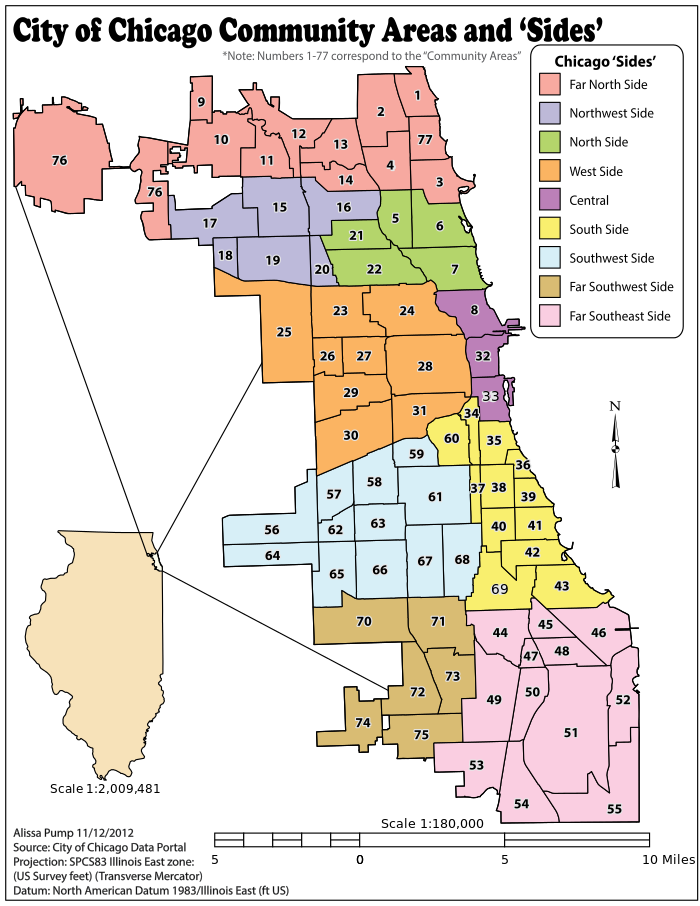

We do see some problem in using this data. Although it does use some logic, some codes are not in line with some kind of proximity. For instance 77 is inconsistant. 76 will be important because it represent the Chicago airport. The following is having a look at how much are the taxi drivers driving passenger each day.

In [ ]:
# how long are taxi driver driving passager
df2 = df[ ['taxi_id','fare','trip_start_timestamp','trip_miles','trip_seconds']]
df2['date_dt'] = df2.apply(lambda row: datetime.datetime.strptime(row['trip_start_timestamp'] ,'%Y-%m-%d %H:%M:%S').date(), axis=1)
df2['counter']  = 1
df2 = df2[(df2.trip_seconds >0)]
df2=df2.groupby(['taxi_id','date_dt']).agg({'trip_seconds': [np.sum]}).sort_values(ascending=False, by='taxi_id')
q = [0.99,0.95,0.9,0.80,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
quant = df2.quantile(q=[0.99,0.95,0.9,0.80,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01])/3600
quant['q']=q

quant.plot(x=('trip_seconds','sum') , y=('q',)  )
plt.title("")
plt.ylabel('% of drivers having a passenger for less than')
plt.ylabel('number of hours carrying a passenger')

We try to determine whether drivers spend a lots of time waiting. With the above graph, we see that 50% of the drivers have a passenger for less than 2h30. Only 7% are carrying passenger for more than 5 hours.

## 2. Data cleaning (high level)

Having seen some of the high level data issue, we correct them

In [ ]:
def data_cleaning(df):
    '''
    INPUT:
    df - Panda data frame with the original data from the datset    
    OUTPUT:
    df5 -  a new data frame with the following characteristic
      1. take only rides with fare <200 and miles <100, second<10000
      2. non zeroe rides for time, fare, second
      3. non na on comunity area creat date_dt filed with datetime object
      4.
    '''
    # on the fare
    df = df[df.trip_seconds > 0]
    df = df[df.fare > 0]
    df = df[df.trip_miles > 0]
    df = df[(df.trip_seconds <10000)]
    df = df[(df.fare <200)]
    df = df[(df.trip_miles <100)]
    df = df.dropna(axis = 0, subset = ['pickup_community_area'])
    df['date_dt'] = df.apply(lambda row: datetime.datetime.strptime(row['trip_start_timestamp'] ,'%Y-%m-%d %H:%M:%S').date(), axis=1)

    return df
df=data_cleaning(df)
df.describe()

## 3. Business Problems

#### We answer the following questions through this notebook: 
1. Which Neighborhoods are the most attractive for taxi drivers?
2. Explain taxi revenue per month ?  (is there a strategy to adopt?) in terms of neighborhood?
3. What time to operate to maximise the revenue? Which day should you work? When to go to the airport for picking up clients?



To answer the above questions, we will use the following analysis

To answer question 1, we will have a look at 2 aspects: whether some neightborhood have a deficit of pickup versus dropoff. This will help to see where some people may be waiting for taxi. The second aspect is to have a look is aiming for longer rides does lead to larger monthly revenue or whether we should prefer shorter rides.

For question 2, we will perform regression analysis to see whether taxis spending more time in some areas have higher revenues

For question 3, we will build up from analysing day that generate more revenue for taxis, to hours generating more revenue and then combine the 2 to see the best time to work over a weekly time period 

## 4. Data preparation

## 4. Best pickup location ? 

We are interested in the neighborhood themselves. Which ones are more attractive and lead to long rides.
First, we can have a look at the community area driving the most rides

In [ ]:
status_vals = df.pickup_community_area.value_counts()
# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.
temp_df = status_vals.iloc[0:5] 
print( status_vals.iloc[0:status_vals.shape[0]].sum()/df.shape[0] );
(temp_df/df.shape[0]).plot(kind="bar");
plt.title("Community area code with largest number of pickup");
plt.ylabel('% of rides intra Chicago from:')

No surprisingly, the most rides are originating from the downtown, some close suburb and the airport. 
The we can have a look if some areas drive more dropoff than pickup

In [ ]:
dropoff_vals = df.dropoff_community_area.value_counts()
# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.
temp_df2 = dropoff_vals -status_vals
temp_tf2 = temp_df2.sort_values()
temp_tf2 = temp_tf2.iloc[ [0,1,2,3,4 , 72,73,74,75,76] ]
print(temp_tf2.plot.bar());
plt.title("5 largest deficit in dropoff and pickup");
plt.ylabel('dropoff-pickup')


more pick up than dropoff. This makes sens for out of town dropoff data.
The largest deficits (more pickup than dropoff) are in the CBD areas (non-residential) and at the airport. 
The areas with most more dropoff than pickup are typically in the residential area near the city center. These are typically wealthy neighborhood of Chicago. 

In [ ]:
temp_df2  = df.groupby(['pickup_community_area']).trip_total.sum().sort_values(ascending=False)
temp_df2=temp_df2.iloc[0:5]
(temp_df2).plot(kind="bar");
plt.title("Community area code with largest revenue");

Revenue weighted, the airport generate almost as much revenue as dowtown due to longer rides.

In [ ]:
#First we do some data manipulation 
df3 = df[ ['taxi_id','fare','trip_start_timestamp','trip_miles','trip_seconds','date_dt']]
df3 = df3[~(df3 == ' ').any(axis=1)]
temp= df3['trip_start_timestamp'][3]
df3['ratio'] = df3.fare/df3.trip_seconds
df3=df3.groupby(['taxi_id','date_dt']).agg({'fare': [np.sum, np.mean] , 'trip_miles':[np.sum , np.mean], 'ratio':[np.mean] , 'trip_seconds':[np.sum , np.mean] }).sort_values(ascending=False, by='taxi_id')
df3['counter']=df3['fare']['sum']/df3['fare']['mean']
df3['counter_miles']=df3['trip_miles']['sum']/df3['trip_miles']['mean']


We try to see if the drivers taking longer rides do make more revenue

In [ ]:
# 
n_bucket = 20
output = pd.Series(20)
output2 = pd.Series(20)
for i in range(n_bucket):
    output[ int(i*50) ] = df3['trip_miles']['mean'][(df3['fare']['sum']<=(i+1)*50) & (df3['fare']['sum']>(i)*50) ].mean()
for i in range(n_bucket):
    output2[ int(i*5) ] = df3['trip_seconds']['mean'][(df3['fare']['mean']<=(i+1)*5) & (df3['fare']['mean']>(i)*5) ].mean()
plt.plot(output)
plt.ylabel('average trip milage')
plt.xlabel('daily revenue')
plt.show()
plt.plot(output2)
plt.ylabel('average second')
plt.xlabel('average fare per ride')
plt.show()

is it true that some drivers will always hunt for long rides?

while longer rides in mile does lead to more income but longer trip in second does not (probably link to  the traffic jam).
So what is the game? avoid traffic jame to make more money.

Taxi get the number of pickup per neighborhood?



for explaining the salary maybe we should explain the number of ride or the length of ride, we do need one hot encoding for the neighboorhoods


## 5. Revenue explanation

Can the revenue per day/month be explained by other factors than just the milage (which is the obvious one). Can it be explained by the location? of the pickups?

In [ ]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


In [ ]:
# for the analysis, to get consistent data, we regroup some area
downtown_area=[8,32,33]  # 3 downtown area, mostly CBD, non-residential
airport = 76 #ariport
#close suburb
close_surburb=np.concatenate([np.arange(5,8),np.arange(15,32),np.arange(34,44),np.arange(56,69)])
#far away subburb
far_surburb= np.concatenate([np.arange(1,5), np.arange(9,15),np.arange(70,76),np.arange(44,56)])

In [ ]:
def create_data_regression(df,downtown_area,airport,close_surburb,far_surburb):
    '''
    INPUT:
    df - Panda data frame with the original data from the datset  
    variables grouping the community codes
    OUTPUT:
    df5 -  a new data frame with the following characteristic
      1. create area fields for the 4 designed area
      2. create dummies for each area (numerical ones)
      3. compute that ratio of ride starting in area/community area
      4. column of day of the week
    '''    
    df_loc = df[ ['taxi_id','fare','trip_start_timestamp','pickup_community_area']]
    df_loc = df_loc[~(df_loc == ' ').any(axis=1)]
    df_loc['downtown_area'] = df_loc.apply(lambda row: int(np.isin(downtown_area,row.pickup_community_area ).any()) , axis=1)
    df_loc['airport'] = df_loc.apply(lambda row: int(np.isin(airport,row.pickup_community_area ).any()) , axis=1)
    df_loc['close_surburb'] = df_loc.apply(lambda row: int(np.isin(close_surburb,row.pickup_community_area ).any()) , axis=1)
    df_loc['far_surburb'] = df_loc.apply(lambda row: int(np.isin(far_surburb,row.pickup_community_area ).any() ), axis=1)
    df_loc=create_dummy_df(df_loc, cat_cols=['pickup_community_area'], dummy_na=False)
    df_loc['counter']= 1
    df_loc=df_loc.groupby(['taxi_id']).sum().sort_values(ascending=False, by='taxi_id')
    columns = df_loc.columns[1:(df_loc.shape[1])]
    for i_col in columns:
        if i_col != 'counter':
            df_loc[i_col]=df_loc[i_col]/df_loc.counter
    df_loc['constant']= 1
    print(df_loc.mean())
    return df_loc

df_loc=create_data_regression(df,downtown_area,airport,close_surburb,far_surburb)

So we have prepared the data. We now try to fit a linera regrassion only with downtown, airport and couter to see which one should be prioritized


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test= train_test_split(df_loc[  ['counter','airport','downtown_area','constant' ] ]   ,df_loc['fare'], test_size=0.4, random_state=42)
#Split into train and test
X_train_counter, X_test_counter, y_train_counter, y_test_counter= train_test_split(df_loc[  ['counter','constant' ]]   ,df_loc['fare'], test_size=0.4, random_state=42)

#Predict and score the model
lm_model = LinearRegression(normalize=True)
output = lm_model.fit(X_train, y_train)
lm_model_counter = LinearRegression(normalize=True)
output_counter = lm_model_counter.fit(X_train_counter, y_train_counter)
y_test_preds = lm_model.predict(X_test)# Predictions here using X_2 and lm_2_model
r2_test = r2_score(y_test.values, y_test_preds)
y_test_preds_counter = lm_model_counter.predict(X_test_counter)# Predictions here using X_2 and lm_2_model
r2_test_counter = r2_score(y_test_counter.values, y_test_preds_counter)
#Rsquared and y_test
print(r2_test )
print(r2_test_counter )
print(lm_model.coef_)
print(lm_model_counter.coef_)

Downtown rides tend to have a lower impact than airport ride, which is in line with the fact the airport rides are longer.

Next we try to see via non-parametric statistics whether the driver should prefer some areas

In [ ]:
print(df_loc.mean().fare)
q = np.arange(0.01,0.99,0.01) 
df_q=pd.DataFrame({'downtown_area':np.zeros(len(q)), 'close_surburb':np.zeros(len(q)), 'airport':np.zeros(len(q)),'far_surburb':np.zeros(len(q))})
for i_q in range(len(q)):
    df_q['downtown_area'][i_q] = df_loc[df_loc.close_surburb <q[i_q]].mean().fare
    df_q['close_surburb'][i_q] =df_loc[df_loc.downtown_area <q[i_q]].mean().fare
    df_q['airport'][i_q] =df_loc[df_loc.airport <q[i_q]].mean().fare
    df_q['far_surburb'][i_q] =df_loc[df_loc.far_surburb <q[i_q]].mean().fare
df_q.index=q
df_q.plot();

We see that the close surburb should be avoided,

## 6. What day? What Time?

We build the analysis in the folowing sequence: 
- some data preparation 
- which data should you drive?
- which time?
- which time of the week

In [ ]:
#first we split date and time, find weekday and period of the day
import warnings
warnings.filterwarnings("ignore")
def create_data_temporal(df):
    '''
    INPUT:
    df - Panda data frame with the original data from the datset    
    OUTPUT:
    df5 -  a new data frame with the following characteristic
      1. take only rides with far <200 and miles <100
      2. datetime stampe split into time and date
      3. column of day of the week
      4. column of time of the day (night,morning,afternoon,night)    
    '''
        
    df5 = df[ ['taxi_id','fare','trip_start_timestamp','trip_miles','trip_seconds','date_dt']]

    #split the time stamps and get the right day
    df5['time_dt'] = df5.apply(lambda row: datetime.datetime.strptime(row['trip_start_timestamp'] ,'%Y-%m-%d %H:%M:%S').time(), axis=1)
    days=['Monday', 'Tuesday','Wednesday', 'Thursday' , 'Friday', 'Saturday', 'Sunday']
    part_of_days=['night', 'morning','afternoon', 'evening' ]
    df5['day1']  = df5.apply(lambda row: datetime.date.weekday(row['date_dt']), axis=1)  
    df5['day']  = df5.apply(lambda row: days[row['day1']], axis=1)  
    df5['part_of_day']=0
    # get the time of the day.  
    df5['night']  = df5.apply(lambda row: 1 if(row['time_dt']>datetime.time(hour=6)) else 0, axis=1) 
    df5['morning']  = df5.apply(lambda row: 1 if( (row['time_dt']>datetime.time(hour=12)))  else  0, axis=1) 
    df5['afternoon']  = df5.apply(lambda row: 1 if( (row['time_dt']>datetime.time(hour=18)))  else 0, axis=1) 
    df5['part_of_day1']  = df5['night']+df5['morning'] +df5['afternoon'] 
    df5['part_of_day']  = df5.apply(lambda row: part_of_days[row['part_of_day1']], axis=1)  
    df5.head(10)
    df5.sort_values(by = ['day1' , 'part_of_day1'])
    return df5
#    df5.head(10)
df5 = create_data_temporal(df)
df5.head()

First, what day should you drive?

In [ ]:
#day of the week analysis   largest revenue per driver
#one issue we run into: sorting the day, and part_of_day, therefore we keep 
# a numeric value to ease the sorting.
df_loc=df5.groupby(['day' , 'day1']).agg( {'fare': np.sum, 'day':pd.Series.value_counts})
df_loc['fare_per_ride']= df_loc['fare']/df_loc['day']
df_loc2=df5.groupby([ 'date_dt']).agg({ 'taxi_id':pd.Series.nunique, 'fare': np.sum ,'day': np.max,'day1': np.max })
#revenue per day per taxi
df_loc2['revenue_per_taxi']=df_loc2['fare']/df_loc2['taxi_id']
df_loc2=df_loc2.groupby([ 'day','day1']).revenue_per_taxi.mean()
df_loc['revenue_per_day']=df_loc2
df_loc= df_loc.sort_values(by='day1')
print(df_loc)
#plot it
xaxis=['Monday', 'Tuesday','Wednesday', 'Thursday' , 'Friday', 'Saturday', 'Sunday']
plt.plot(xaxis, df_loc['revenue_per_day'])
plt.ylabel('average revenue per taxi')

From the day analysis, it is clear that the weekends are not so revenue generating. A taxi driving on saturday only makes 147$ but makes 187 on Friday. One drawback of this analysis is that to be more precise, we would need the time at which the drivers start working and stop working.


In [ ]:
#next which part of the day is more revenue generating
df_loc=df5.groupby(['part_of_day', 'part_of_day1']).agg( {'fare': np.sum, 'part_of_day':pd.Series.value_counts})
df_loc['fare_per_ride']= df_loc['fare']/df_loc['part_of_day']
df_loc2=df5.groupby([ 'date_dt','part_of_day','part_of_day1']).agg({ 'taxi_id':pd.Series.nunique, 'fare': np.sum })
df_loc2['revenue_per_taxi']=df_loc2['fare']/df_loc2['taxi_id']
df_loc2=df_loc2.groupby([ 'part_of_day' , 'part_of_day1']).revenue_per_taxi.mean()
df_loc['revenue_per_part_day']=df_loc2
df_loc = df_loc.sort_values(by='part_of_day1')

# Chart time of the day / revenue per taxi durign this time period
xaxis=['night', 'morning','afternoon', 'evening' ]
plt.plot(xaxis, df_loc['revenue_per_part_day'])
plt.ylabel('average revenue per taxi depending on the part of the day')

No real doubt or surprice here, afternoon and evening are more revenue generating

In [ ]:
df_loc2=df5.groupby([ 'date_dt','part_of_day' ,'part_of_day1','day1']).agg({ 'taxi_id':pd.Series.nunique, 'fare': np.sum,'day':np.max ,'day1':np.max , 'part_of_day1':np.max  })
df_loc2['revenue_per_taxi']=df_loc2['fare']/df_loc2['taxi_id']
df_loc2=df_loc2.groupby([ 'day', 'part_of_day']).agg({ 'revenue_per_taxi': np.mean , 'part_of_day1':np.max,'day1':np.max })
df_loc2= df_loc2.sort_values(by=['day1','part_of_day1'])

df_loc2 = df_loc2.drop(columns = ['day1','part_of_day1'])

#chart bar: for each time period during 1 week
df_loc2.plot(kind='bar')
plt.ylabel('average revenue per taxi depending on the part of the day')

Putting is all together, we do get another picture. The night during the week are to be avoided. But the morning are almost as good as the afternoon or the evening during the first 4 days of the weak.
During the weekend, there is a large peak on sunday night due to the clubing and go out during the that night.